# Programming Assignment 3: Backpropagation and Neural Networks
In class we have learned backpropagation algorithm and neural networks. In this section, we will build a simple neural network and use backpropagation algorithm to train the model to fit an arbitrary function. We are going to use `numpy` and `matplotlib` in Python, first let us import these packages.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

Our experiment consists of three parts:
1. Model implementation, including linear layer, several activation functions and MSE loss.
2. Generate training set and train our model. 
3. Analytical questions and bonus.

You need to write some codes and answer some analytical questions during our experiment.


## Pre-knowledge

We will use some specific programming skills (i.e., [`Class`](https://www.w3schools.com/python/python_classes.asp), [`Inheritance`](https://www.w3schools.com/python/python_inheritance.asp), and [`Callable`](https://www.w3schools.com/python/ref_func_callable.asp)) in this assignment. If you are not familiar with them, you can click the corresponding hyperlink to get a reference.


## Model Implementation
### Basic Knowledge
A neural network may consist of multiple layers, which includes input layer, output layer and multiple hidden layers. 
Each layer could do both forward propagation and backward propagation. Now, assume current layer is the $l$-th layer, and we denote current layer as a function $f(X, W)$, where $X$ is the input data and $W$ is the weights. 

- *Note that some types of layers don't have weights, which means they don't need to be updated.*

In forward propagation, the layer takes input data $X$ and computes the output $Y = f(X, W)$, which will be used as input data of $(l+1)$-th layer. 

Backward propagation is a little more complicated. Denote the loss function of model as $\mathcal L$. In backward propagation, we first receive a output gradient $\frac{\partial \mathcal L}{\partial f}$ which is passed from the $(L+1)$-th layer. What we want is to compute the gradients of $X$ and $W$. According to the chain rule, we have:
$$
\frac{\partial \mathcal L}{\partial X} = \frac{\partial \mathcal L}{\partial f}\frac{\partial f}{\partial X},
\frac{\partial \mathcal L}{\partial W} = \frac{\partial \mathcal L}{\partial f}\frac{\partial f}{\partial W}.
$$
Further, $\frac{\partial \mathcal L}{\partial X}$ will be backward-passed to the $(l-1)$-th layer, and $\frac{\partial \mathcal L}{\partial W}$ can be used to update the weights.

### Base Class
Because all layers need to do forward propagation and backward propagation, we will define a base class first. All kinds of other layers will be derived from this class. 

In [2]:
class Module:
    def __init__(self):
        self.with_weights = False
        pass
    def forward(self):
        pass
    def backward(self):
        pass
    def __call__(self, *inputs, **kwargs):
        return self.forward(*inputs, **kwargs)
# learning rate

Note that we define the `__call__` method, which make the class callable. This means we can call the object of `Module` class like a function:
```py
model = Module()
# equavilent to model.__call__()
model()
```



In `__call__` function, we pass the parameters to `forward` function and return the results. So we could write *pytorch*-style code and do forward propagation by call the object. 
```py
# forward propagation
# equavilent to model.forward(input)
model(input)
```

The `self.with_weights` is an indicator of whether this layer's parameters will be updated in the backpropagation process. You will find more explanation in the later section about simple neural network.


### Linear Layer
A linear unit applies a linear transformation to the incoming data:
$$
\mathbf y =  \boldsymbol w^T \boldsymbol x + b,
$$
where $\boldsymbol x \in \mathbb R^{n}$ is the input array, $\boldsymbol w \in \mathbb R^{n}$ is the weight and $b \in \mathbb R$ is the bias. Here, $n$ is the input dimension. 

![](./fig1.png) 

A linear layer consists of multiple linear units, the number of linear units also determines the output dimension:

![](./fig2.png) 

We use $W \in \mathbb R ^{n\times k}, \mathbf b \in \mathbb R^{1 \times k}$ to denote the weight and bias of linear layer respectively, where $W  = \left[\boldsymbol w^{(1)},..., \boldsymbol w^{(k)}\right], \mathbf b = \left[ b^{(1)},...,b^{(k)} \right]$. The forward propagation of linear layer can be formulated as:
$$
\mathbf y = XW + \mathbf b,
$$
where $X \in \mathbb R^{m \times n}$ is the input array, $y \in \mathbb R ^{m \times k}$ is the output array. Here $m$ is the batch size, so we can compute a whole batch of samples together. 

For backward propagation, we have received an output gradient $\frac{\partial \mathcal L}{\partial Y}$, which is a $m \times k$ matrix. And we have:
$$
\frac{\partial \mathcal L}{\partial W} = X^T \frac{\partial \mathcal L}{\partial Y}, \quad \frac{\partial \mathcal L}{\partial \mathbf b} = \mathbf 1^T \frac{\partial \mathcal L}{\partial Y}, \quad \frac{\partial \mathcal L}{\partial X}= \frac{\partial \mathcal L}{\partial Y} W^T,
$$
where $\mathbf 1 \in \mathbb R^m$ is a vector with all elements equal to $1$. 
For detailed derivation, refer to [Backpropagation for a Linear Layer](http://cs231n.stanford.edu/handouts/linear-backprop.pdf).


#### Q1 (2 points). Implement the forward propagation and backward propagation of linear layer. For the forward propagation, the return value should be the value of `f(x)` at the given input `x`. For the backward propagation, we compute the gradient with respect to the input $\frac{\partial \mathcal L}{\partial X}$ as well as with respect to the layer weight $\frac{\partial \mathcal L}{\partial W}$ and $\frac{\partial \mathcal L}{\partial b}$. We will directly do the gradient descent update (e.g., $W \leftarrow W - lr * X^T \frac{\partial \mathcal L}{\partial Y}$) on `self.W` and `self.b` based on the computed gradient;  Then return the value of $\frac{\partial \mathcal L}{\partial X}$, so that it can be passed to the previous layer. (Please note that `res` is just a variable holding the results returned from the function call. )

In [3]:
class Linear(Module):
    def __init__(self, input_dim, output_dim):
        super(Linear, self).__init__()
        # Initialize weights
        self.W = np.random.randn(input_dim, output_dim) * 1e-2
        self.b = np.zeros((1, output_dim))
        # The linear layer's parameters should be updated
        self.with_weights = True
        
    def forward(self, input_array):
        res = np.zeros((input_array.shape[0], self.W.shape[1]))
        
        ## start of your code
        res = np.dot(input_array, self.W) + self.b
        ## end of your code
        
        return res

    def backward(self, input_array, output_gradient, lr = 0.05):
        res = np.zeros_like(input_array)
        ## start of your code
        # 1. compute new output_gradient, which will be backward-passed to previous layer
        res = np.dot(output_gradient, self.W.T)
        # 2. compute the gradient and update W, b
        dW = np.dot(input_array.T, output_gradient)
        db = np.sum(output_gradient, axis=0, keepdims=True)

        self.W -= lr * dW
        self.b -= lr * db
        ## end of your code
        
        return res

#### Q2 (2 points). Here, we use a simple example to test our code. We set $m = n = k = 2$, $X = \begin{bmatrix}1 & 3\\2 & 5\end{bmatrix}$, $W = \begin{bmatrix}2 & 1\\2 & 1\end{bmatrix}$, $\mathbf b = \mathbf 0^T$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. Please calculate the result for forward propagation, backward propagation, and updated parameters. We set learning rate as $0.05$ here.

*Your Answer:*

### 1. Forward Propagation
$$
Y = \begin{bmatrix} 1 & 3 \\ 2 & 5 \end{bmatrix} \begin{bmatrix} 2 & 1 \\ 2 & 1 \end{bmatrix} + \begin{bmatrix} 0 & 0 \end{bmatrix}
$$
$$
Y = \begin{bmatrix} 1 \cdot 2 + 3 \cdot 2 & 1 \cdot 1 + 3 \cdot 1 \\ 2 \cdot 2 + 5 \cdot 2 & 2 \cdot 1 + 5 \cdot 1 \end{bmatrix} = \begin{bmatrix} 8 & 4 \\ 14 & 7 \end{bmatrix}
$$

### 2. Backward Propagation

1. **Calculate the input gradient** $\frac{\partial \mathcal{L}}{\partial X}$:
   $$
   \frac{\partial \mathcal{L}}{\partial X} = \frac{\partial \mathcal{L}}{\partial Y} W^T
   $$
   $$
   \frac{\partial \mathcal{L}}{\partial X} = \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \begin{bmatrix} 2 & 2 \\ 1 & 1 \end{bmatrix} = \begin{bmatrix} 3 & 3 \\ 3 & 3 \end{bmatrix}
   $$

2. **Compute gradients and update parameters**:
   - **Weight gradient**:
   $$
   \frac{\partial \mathcal{L}}{\partial W} = X^T \frac{\partial \mathcal{L}}{\partial Y}
   $$
   $$
   \frac{\partial \mathcal{L}}{\partial W} = \begin{bmatrix} 1 & 2 \\ 3 & 5 \end{bmatrix} \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} = \begin{bmatrix} 3 & 3 \\ 8 & 8 \end{bmatrix}
   $$

   - **Bias gradient**:
   $$
   \frac{\partial \mathcal{L}}{\partial b} = \sum \frac{\partial \mathcal{L}}{\partial Y} = \begin{bmatrix} 2 & 2 \end{bmatrix}
   $$

   - **Update weights and bias**:
   $$
   W \leftarrow W - lr \cdot \frac{\partial \mathcal{L}}{\partial W} = \begin{bmatrix} 2 & 1 \\ 2 & 1 \end{bmatrix} - 0.05 \cdot \begin{bmatrix} 3 & 3 \\ 8 & 8 \end{bmatrix} = \begin{bmatrix} 2 - 0.15 & 1 - 0.15 \\ 2 - 0.4 & 1 - 0.4 \end{bmatrix} = \begin{bmatrix} 1.85 & 0.85 \\ 1.6 & 0.6 \end{bmatrix}
   $$
   $$
   b \leftarrow b - lr \cdot \frac{\partial \mathcal{L}}{\partial b} = \begin{bmatrix} 0 & 0 \end{bmatrix} - 0.05 \cdot \begin{bmatrix} 2 & 2 \end{bmatrix} = \begin{bmatrix} -0.1 & -0.1 \end{bmatrix}
   $$

### Final Results
- **Forward propagation output**: 
  $$
  Y = \begin{bmatrix} 8 & 4 \\ 14 & 7 \end{bmatrix}
  $$
- **Input gradient**: 
  $$
  \frac{\partial \mathcal{L}}{\partial X} = \begin{bmatrix} 3 & 3 \\ 3 & 3 \end{bmatrix}
  $$
- **Updated weights**: 
  $$
  W = \begin{bmatrix} 1.85 & 0.85 \\ 1.6 & 0.6 \end{bmatrix}
  $$
- **Updated bias**: 
  $$
  b = \begin{bmatrix} -0.1 & -0.1 \end{bmatrix}
  $$


You can compare your calculation results and the following code output results:

In [4]:
test_linear = Linear(2, 2)
input_array = np.array([[1., 3.],[2., 5.]])
test_linear.W = np.array([[2., 1.], [2., 1.]])
forward_res = test_linear(input_array)
print("forward:\n", forward_res)
# output dimension
output_gradient =  np.ones((2,2))
backward_res = test_linear.backward(input_array, output_gradient, lr=0.05)
print("backward:\n", backward_res)
print("W:\n", test_linear.W)
print("b:\n", test_linear.b)

forward:
 [[ 8.  4.]
 [14.  7.]]
backward:
 [[3. 3.]
 [3. 3.]]
W:
 [[1.85 0.85]
 [1.6  0.6 ]]
b:
 [[-0.1 -0.1]]


### Activation Layer
In this section, we will implement two types of activation layers. Activation layers do not change the dimension of input array. Given an activation function, the activation layer will apply the activation function on each element of the input array and get the output that has a same shape with input array. Also, we don't need to update the parameter.

![](./fig3.png)

#### ReLU
ReLU is an activation function defined as the positive part of its argument:
$$
\text{R}(x) = x^+ = \max(0, x).
$$
We have:
$$
\text{R}'(x) = \left\{\begin{matrix}1&x > 0\\0 & \text{otherwise}\end{matrix}\right.
$$
So for backward propagation of ReLU layer, if the input element is negative, the corresponding element in output gradient $\frac{\partial \mathcal L}{\partial Y}$ will be set to $0$, other elements will stay the same.


#### Q3 (2 points). Implement the forward propagation and backward propagation of ReLU layer.

In [5]:
class ReLU(Module):
    def __init__(self):
        super(ReLU, self).__init__()
        pass
    
    def forward(self, input_array):
        res = np.zeros_like(input_array)
        
        ## start of your code
        res = np.maximum(0, input_array)
        ## end of your code
        
        return res

    def backward(self, input_array, output_gradient):
        res = np.zeros_like(input_array)
        
        ## start of your code
        res[input_array > 0] = output_gradient[input_array > 0]
        ## end of your code
        
        return res

To test ReLU layer, we set input $X = \begin{bmatrix}2 & -2\\-2 & 2\end{bmatrix}$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\text{R}(X) =  \begin{bmatrix}2 & 0\\0 & 2\end{bmatrix}.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial X} =  \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}.
$$

In [6]:
test_relu = ReLU()
input_array = np.array([[2., -2.],[-2., 2]])
forward_res = test_relu(input_array)
print("forward:\n", forward_res)
output_gradient =  np.ones((2,2))
backward_res = test_relu.backward(input_array, output_gradient)
print("backward:\n", backward_res)

forward:
 [[2. 0.]
 [0. 2.]]
backward:
 [[1. 0.]
 [0. 1.]]


#### Sigmoid
Sigmoid function is an activation function defined by the formula:
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$
We have
$$
\sigma'(x) =\sigma(x) \left(1 - \sigma(x)\right)
$$
So for backward propagation of Sigmoid layer, we compute $\sigma'(x)$ for each input element $x$ and multiply it with the corresponding element in output gradient $\frac{\partial \mathcal L}{\partial Y}$.


Implementation of the forward propagation and backward propagation of Sigmoid layer.

In [7]:
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()

    def forward(self, input_array):
        return 1 / (1 + np.exp(-input_array))

    def backward(self, input_array, output_gradient):
        return output_gradient * self.forward(input_array) * (1 - self.forward(input_array))

To test Sigmoid layer, we set input $X = \begin{bmatrix}2 & -2\\-2 & 2\end{bmatrix}$, $\frac{\partial \mathcal L}{\partial Y}= \begin{bmatrix}1 & 1\\1 & 1\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\sigma(X) =  \begin{bmatrix}0.88079708 &0.26894142\\0.26894142 & 0.88079708\end{bmatrix}.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial X} =  \begin{bmatrix}0.10499359 & 0.19661193\\0.19661193 & 0.10499359\end{bmatrix}.
$$

In [8]:
test_sigmoid = Sigmoid()
input_array = np.array([[2., -1.],[-1., 2]])
forward_res = test_sigmoid(input_array)
print("forward:\n", forward_res)
output_gradient =  np.ones((2,2))
backward_res = test_sigmoid.backward(input_array, output_gradient)
print("backward:\n", backward_res)

forward:
 [[0.88079708 0.26894142]
 [0.26894142 0.88079708]]
backward:
 [[0.10499359 0.19661193]
 [0.19661193 0.10499359]]


#### MSE Loss
To train our model, we need to define our loss function. Because we want to do a regression problem, we will use mean squared error (MSE) as our loss function:
$$
\text{MSE} = \frac{1}{m}\sum_{i=1}^m\left(\hat y^{(i)} - y^{(i)}\right)^2.
$$
Loss can be considered as a special layer. In forward propagation, it takes the predicted value and true value as input and returns the error. For backward propagation, it will compute the gradients of output layer. Note that we don't need a output gradient here, because it's the final layer in training process.


Implementation of the forward propagation and backward propagation of MSE Loss layer.

In [9]:
class MSELoss(Module):
    def __init__(self):
        super(MSELoss, self).__init__()   
        
    def forward(self, predicted_y, y):
        return np.mean((predicted_y - y) ** 2)

    def backward(self, predicted_y, y):
        return (predicted_y - y) * 2 / len(y)

To test MSE loss, we set predicted value $\hat{ \mathbf y} = \begin{bmatrix}1 \\1\end{bmatrix}$ and true value $\mathbf y = \begin{bmatrix}1.5 \\1.5\end{bmatrix}$. 

For forward propagation, we have a result: 
$$
\text{MSE}  =  0.25.
$$
For backward propagation, we have a result:
$$
\frac{\partial \mathcal L}{\partial \hat{ \mathbf y}} =  \begin{bmatrix}-0.5 \\ -0.5\end{bmatrix}.
$$

In [10]:
test_mse = MSELoss()
pred_y = np.array([[1], [1]])
true_y = np.array([[1.5], [1.5]])
forward_res = test_mse(pred_y, true_y)
print("forward:\n", forward_res)
backward_res = test_mse.backward(pred_y, true_y)
print("backward:\n", backward_res)

forward:
 0.25
backward:
 [[-0.5]
 [-0.5]]


#### Simple Neural Network
By now, we can actually design a neural network with all these layers and loss function. Here, we define a new class to connect all the components.  You just need to list all the layers you want to use by order, and input the list and loss function when construct the model. 

In `forward` function, we will start from the first layer, which takes the original features as input, and the output will be the input data for the next layer. We use a for-loop for forward propagation. All the intermediate input array will be stored for later backward propagation. 

In `backward` function, we firstly compute the loss and output gradient generated from loss function. Then, this output gradient will be passed to output layer. Start from the output layer, we update the parameters and backward-pass the output gradient to previous layers through a reversed for-loop. 

Therefore, by calling `forward` and `backward`, our model will automatically do the propagation and update parameters. However, you need to make sure your design is reasonable. *If the dimensions between different layers don't match, there will be errors.*

In [11]:
class SimpleNN(Module):
    def __init__(self, layers, loss, lr = 0.005):
        super(SimpleNN, self).__init__()    
        self.layers = layers
        self.loss = loss
        self.inputs = [None for _ in range(len(self.layers))]
        self.output = None
        self.loss_value = 1e5
        self.lr = lr
        pass

    def forward(self, input_array):
        current_input = input_array
        for i in range(len(self.layers)):
            self.inputs[i] = current_input
            current_input = self.layers[i](current_input)
        self.output = current_input
        return self.output
        
    def backward(self, y):
        if self.inputs[-1] is None:
            print("call forward first.")
            return
        self.loss_value = self.loss(self.output, y)
        output_gradient = self.loss.backward(self.output, y)
        for i in range(len(self.layers)-1, -1, -1):
            # here we check wheather a layer should be updated in the backpropagation by judging its `.with_weights` value.
            # whether we update the weight is determined by whether the layer has trainable parameters. 
            # for instance, a layer such as x^2 or ||x||^2 does not have a parameter, so we set `.with_weight`` to false.
            if not isinstance(self.inputs[i], np.ndarray):
                self.inputs[i]=self.inputs[i].numpy()
            if self.layers[i].with_weights:
                output_gradient = self.layers[i].backward(self.inputs[i], output_gradient, self.lr)
            else:
                output_gradient = self.layers[i].backward(self.inputs[i], output_gradient)
        self.output = None


### Train the model
Here, we will design a simple neural network. The structure of our model is shown in following figure:

![](./fig4.png)
Our model contains:
- L0, Input layer (shape: $N \times 1$), where $N$ is the batch size.
- L1, Linear layer (shape: $1 \times 80$)
- L2, ReLU layer
- L3, Linear layer (shape: $80 \times 80$)
- L4, ReLU layer
- L5, Output layer (linear layer, shape: $80 \times 1$)

In [12]:
layers = [
    # input layer is input data
    # L1
    Linear(1, 80),
    # L2
    ReLU(),  # Sigmoid(),# 
    # L3
    Linear(80, 80),
    # L4
    ReLU(),  # Sigmoid(),# 
    # L5
    Linear(80, 1)
]
loss = MSELoss()
model = SimpleNN(layers, loss, lr=0.05)

We use this model to approximate the sine function. Our training set $\left\{x^{(i)}, y^{(i)}: i=1,2, \ldots, m\right\}$ is generated by 
$$
y^{(i)}=\sin x^{(i)}, \quad \forall i.
$$

In [13]:
x = np.linspace(-np.pi, np.pi, 100).reshape(-1, 1) 
y = np.sin(x)

Now, train our model and plot the results.

epoch 0/20000, loss: 0.4949970079394144
epoch 500/20000, loss: 0.10472845746647544
epoch 1000/20000, loss: 0.02532385625515483
epoch 1500/20000, loss: 0.003658596125011236
epoch 2000/20000, loss: 0.001043673799746836
epoch 2500/20000, loss: 0.00041197211674588334
epoch 3000/20000, loss: 0.00021302259982872976
epoch 3500/20000, loss: 0.0001298494804432882


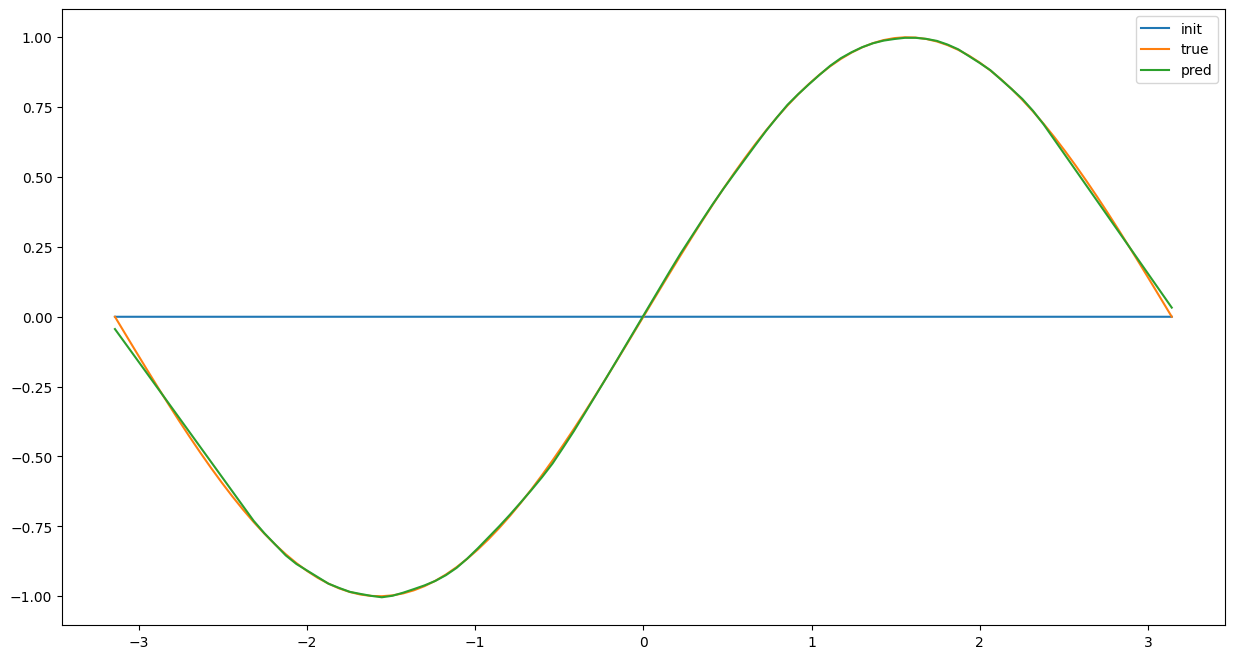

In [14]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")
while epoch < max_iteration and model.loss_value > 1e-4:
    pred_y = model(x)
    model.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model.loss_value))
    epoch += 1
plt.plot(x, pred_y, label="pred")
plt.legend()

### Analytical Questions


**Please make sure you understand how the SimpleNN class works with the layer classes you implemented.**

#### Q4 (2 points). In the training, we use Sigmoid as the activation function. Compare the training speed and results of using Sigmoid and ReLU. Then, change the sample size of the dataset to 1000 (you can also try other sizes), and compare the training speed and results. Please report the running time and loss. Describe the differences and their potential factors.

*Your answer:* 

First we build the neural network model with `Sigmoid` as the activation function.

In [15]:
layers_sigmoid = [
    Linear(1, 80),
    Sigmoid(),
    Linear(80, 80),
    Sigmoid(),
    Linear(80, 1)
]
loss = MSELoss()
model_sigmoid = SimpleNN(layers_sigmoid, loss, lr=0.05)

We use the same dataset which its sample size is 1000.

In [16]:
x = np.linspace(-np.pi, np.pi, 1000).reshape(-1, 1)
y = np.sin(x)

And then train model and plot the required results.

epoch 0/20000, loss: 0.5010418137634388
epoch 500/20000, loss: 0.4994249095016082
epoch 1000/20000, loss: 0.4992310339136999
epoch 1500/20000, loss: 0.4980899047741892
epoch 2000/20000, loss: 0.45471492650707446
epoch 2500/20000, loss: 0.182223862024767
epoch 3000/20000, loss: 0.17284343346481995
epoch 3500/20000, loss: 0.1560942280310939
epoch 4000/20000, loss: 0.13273396964165807
epoch 4500/20000, loss: 0.1061021588110755
epoch 5000/20000, loss: 0.07763121911466864
epoch 5500/20000, loss: 0.04681861031567351
epoch 6000/20000, loss: 0.02977324836954972
epoch 6500/20000, loss: 0.020575663076687945
epoch 7000/20000, loss: 0.018942567809833596
epoch 7500/20000, loss: 0.01680570472390182
epoch 8000/20000, loss: 0.015774917097602967
epoch 8500/20000, loss: 0.014052329108897926
epoch 9000/20000, loss: 0.013113454818992504
epoch 9500/20000, loss: 0.08319154025300608
epoch 10000/20000, loss: 0.010816645095537737
epoch 10500/20000, loss: 0.010029627211119031
epoch 11000/20000, loss: 0.00928571

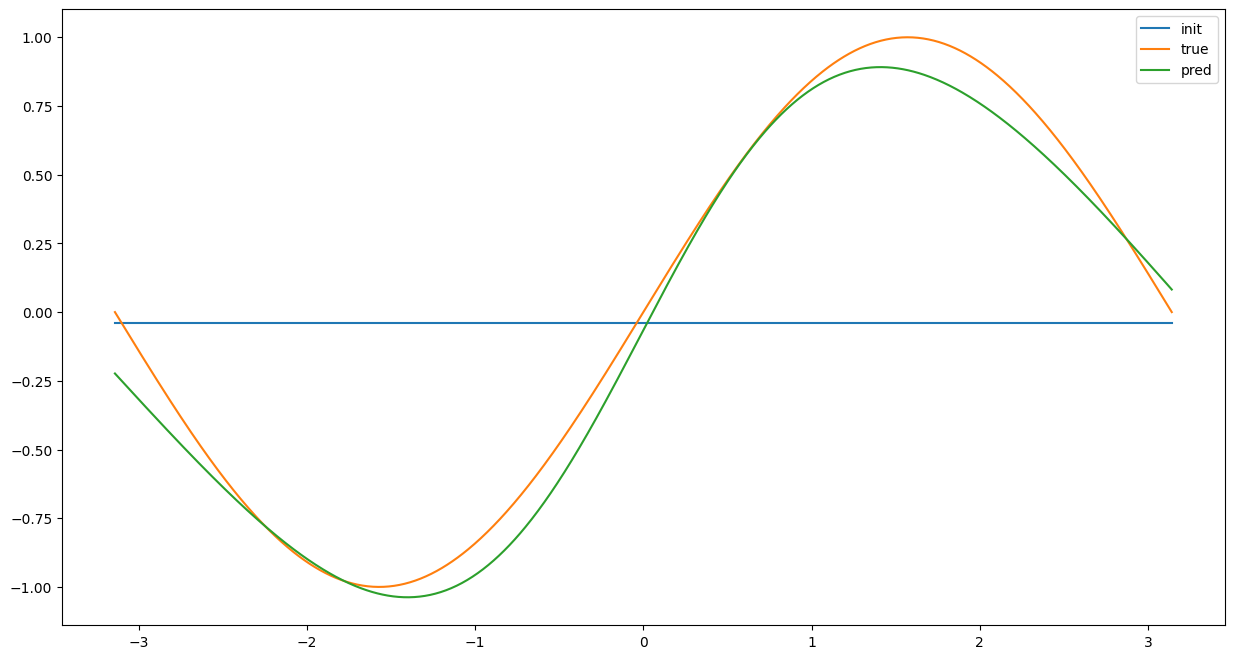

In [17]:
# training
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model_sigmoid.forward(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")

import time
start_time = time.time()

while epoch < max_iteration and model_sigmoid.loss_value > 1e-4:
    pred_y = model_sigmoid.forward(x)
    model_sigmoid.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model_sigmoid.loss_value))
    epoch += 1

end_time = time.time()
print(f"Training time with Sigmoid: {end_time - start_time} seconds")
plt.plot(x, pred_y, label="pred")
plt.legend()
plt.show()


At the same time, we make the same training by using `ReLU` and record the time.

Training time with ReLU: 0.0 seconds


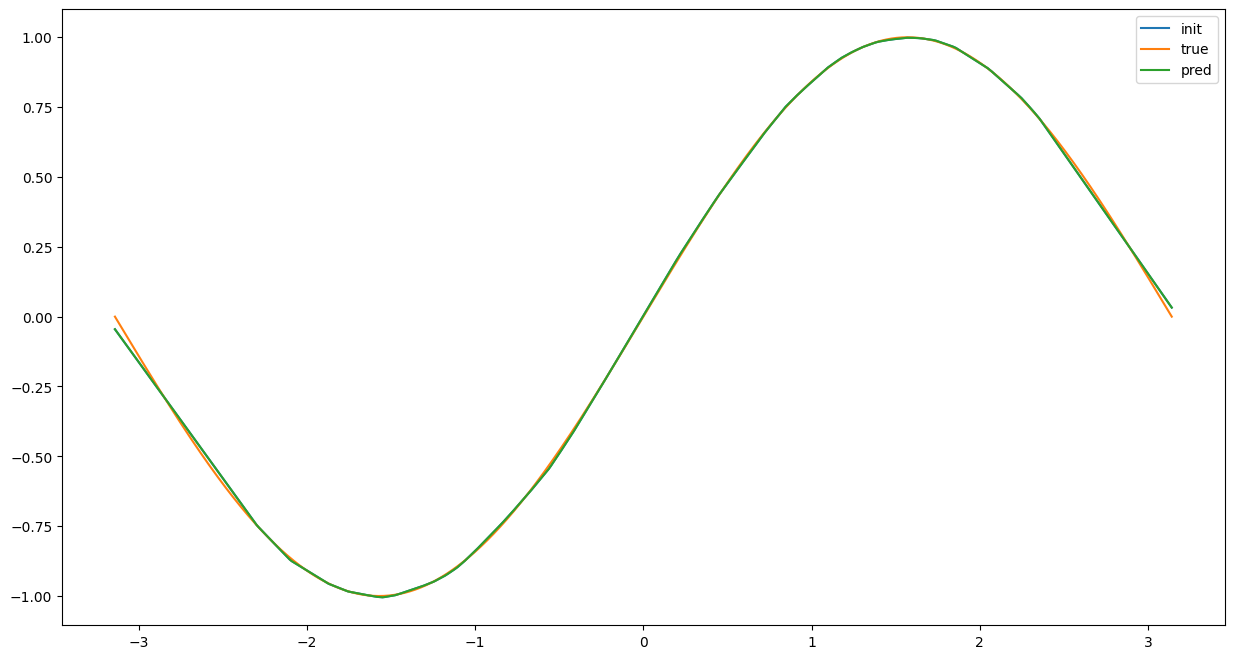

In [18]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")

start_time = time.time()

while epoch < max_iteration and model.loss_value > 1e-4:
    pred_y = model(x)
    model.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model.loss_value))
    epoch += 1
    
end_time = time.time()
print(f"Training time with ReLU: {end_time - start_time} seconds")
plt.plot(x, pred_y, label="pred")
plt.legend()
plt.show()

We can see that: the training time utilizing `Sigmoid` function was approximately 57 seconds, while `ReLU` completed training in just 5 seconds; the loss for `Sigmoid` was 0.0082, while `ReLU` was 0.0001. It can also be seen from the figure that the fit of `Sigmoid` is a bit worse compared to `ReLU`.

**Differences between `Sigmoid` and `ReLU`**

1. **Output Range**:
   - **Sigmoid**: The output is constrained between 0 and 1. This can lead to saturation.
   - **ReLU**: The output is either 0 (for negative inputs) or the input itself (for positive inputs). This unbounded output allows ReLU to effectively handle a wider range of values without saturation.

2. **Gradient Behavior**:
   - **Sigmoid**: The gradient approaches zero for very high or very low input values, which can slow down the learning process significantly due to the vanishing gradient problem. 
   - **ReLU**: The gradient is constant (1) for positive inputs and 0 for negative inputs.
3. **Sparsity**:
   - **Sigmoid**: Activates all neurons in the network to some extent, which can lead to redundant activations and inefficient learning.
   - **ReLU**: Introduces sparsity by turning off neurons (outputting 0) for negative inputs. This can make the network more efficient.
4. **Computational Efficiency**:
   - **Sigmoid**: The computation involves exponentiation, which can be more computationally intensive.
   - **ReLU**: The computation is simpler, involving just a comparison to zero, making it faster to compute.

**Potential Factors Influencing These Differences**

- **Network Architecture**: In deeper networks, the limitations of Sigmoid become more pronounced, leading to ineffective learning and slower convergence compared to ReLU.
- **Data Distribution**: The choice of activation function can interact with the distribution of input data. For example, if inputs are often negative, ReLU may result in many dead neurons (those that always output 0).
- **Regularization**: ReLU's propensity for sparsity can aid in generalization and act as a form of implicit regularization, which can enhance performance on unseen data.
- **Learning Rate**: The impact of the activation function on convergence speed can be influenced by the choice of learning rate; larger learning rates may exacerbate the vanishing gradient problem for Sigmoid.

#### Q5 (2 points). Try to remove all the activation layers. Compare the results and analyze the role of activation layers.

*Your answer:*

First we define a NN without activation function.

In [19]:
# with no activation function
layers_no_activation = [
    Linear(1, 80),  # L1
    Linear(80, 80),  # L3
    Linear(80, 1)   # L5
]
loss_no_activation = MSELoss()
model_no_activation = SimpleNN(layers_no_activation, loss_no_activation, lr=0.05)


Then we training with a model that does not contain an activation layer.

epoch 0/20000, loss: 0.4996406136665771
epoch 500/20000, loss: 0.1967521739631394
epoch 1000/20000, loss: 0.1967521739631394
epoch 1500/20000, loss: 0.1967521739631394
epoch 2000/20000, loss: 0.1967521739631394
epoch 2500/20000, loss: 0.19675217396313938
epoch 3000/20000, loss: 0.19675217396313938
epoch 3500/20000, loss: 0.19675217396313938
epoch 4000/20000, loss: 0.1967521739631394
epoch 4500/20000, loss: 0.19675217396313938
epoch 5000/20000, loss: 0.1967521739631394
epoch 5500/20000, loss: 0.1967521739631394
epoch 6000/20000, loss: 0.1967521739631394
epoch 6500/20000, loss: 0.1967521739631394
epoch 7000/20000, loss: 0.1967521739631394
epoch 7500/20000, loss: 0.19675217396313938
epoch 8000/20000, loss: 0.1967521739631394
epoch 8500/20000, loss: 0.19675217396313938
epoch 9000/20000, loss: 0.1967521739631394
epoch 9500/20000, loss: 0.19675217396313938
epoch 10000/20000, loss: 0.19675217396313938
epoch 10500/20000, loss: 0.19675217396313938
epoch 11000/20000, loss: 0.19675217396313938
ep

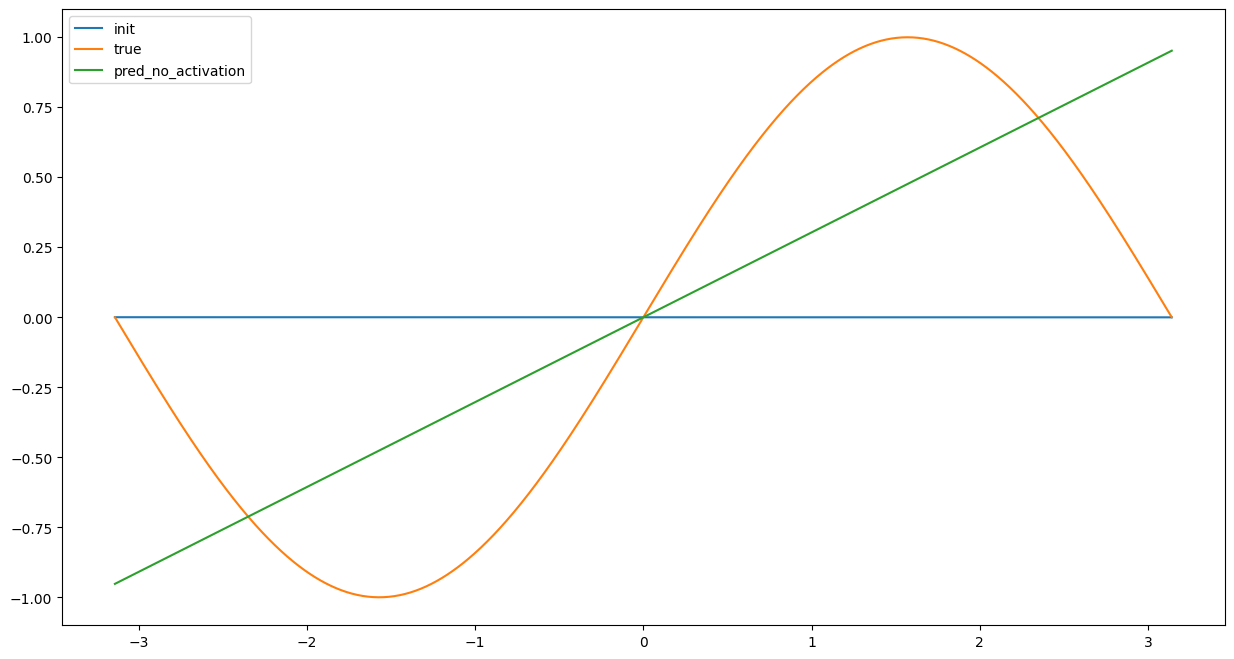

In [20]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y_no_activation = model_no_activation(x)
plt.plot(x, pred_y_no_activation, label="init")
plt.plot(x, y, label="true")

while epoch < max_iteration and model_no_activation.loss_value > 1e-4:
    pred_y_no_activation = model_no_activation(x)
    model_no_activation.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model_no_activation.loss_value))
    epoch += 1

plt.plot(x, pred_y_no_activation, label="pred_no_activation")
plt.legend()
plt.show()


Now we compare the predicted results.

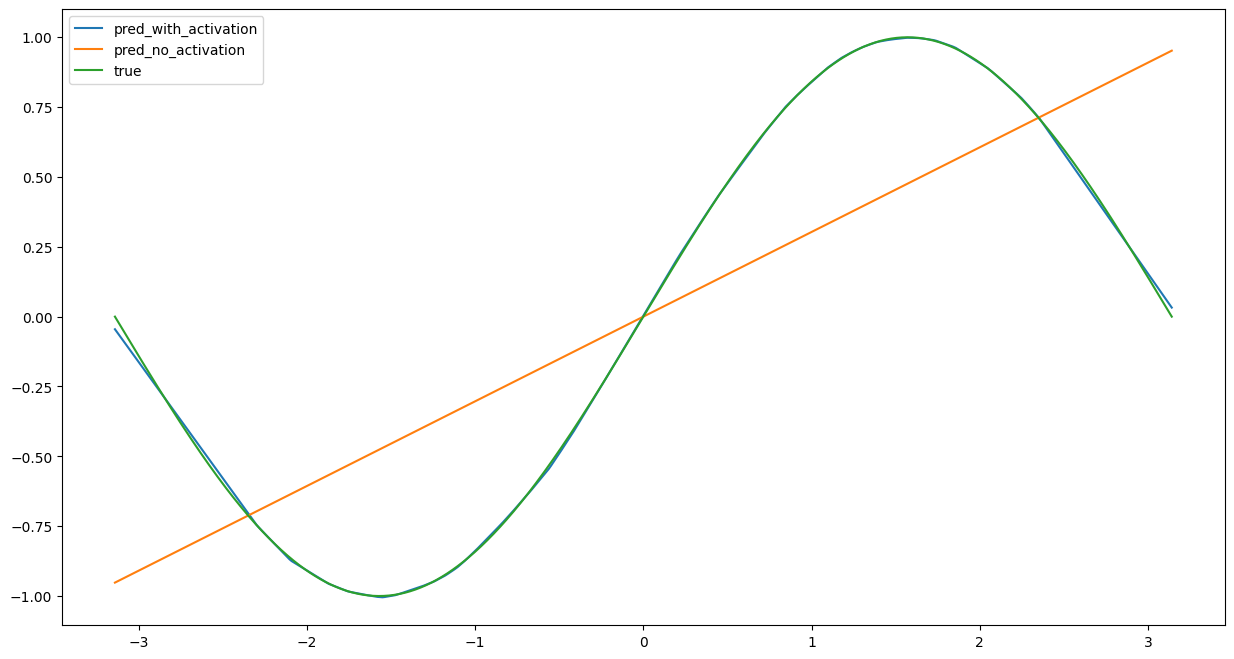

In [21]:
# Compare the training results
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="pred_with_activation")
plt.plot(x, pred_y_no_activation, label="pred_no_activation")
plt.plot(x, y, label="true")
plt.legend()
plt.show()


We can see that without actiavtion layers, NN can only present linear relationships. 

**the Role of Activation Layers**

1. **Learning Ability**: Models with activation layers can learn complex nonlinear relationships, while models without them can only represent linear relationships. Activation layers allow the model to introduce nonlinear transformations, enhancing its learning capacity.

2. **Output Range**: Activation layers constrain the output of each layer, enabling the model to handle input data across different ranges. Without activation layers, outputs are limited to linear transformations, restricting the model's expressive power.

3. **Convergence Speed**: Activation layers typically accelerate model convergence, facilitating faster learning. Removing activation layers may require the model to undergo more iterations to reach convergence.

4. **Generalization Ability**: Activation layers, by introducing nonlinearity, may improve the model's generalization capability, allowing it to better adapt to unseen data. Removing activation layers could lead to overfitting or underfitting on the training data.

### Hint on L2 Regularization

Some students are confused about where to put the L2 regularization of linear layers. You probably think about adding the regularization term when defining the MSELoss, however we cannot get the weights of linear layers in loss layer.

Actually, L2 regularization can be put in the backward propagation of linear layer when updating the weights. With L2 regularization term, our final loss function becomes:

$$
\mathcal{L}(X, W) = MSE + \lambda \sum_{i=1}^{|L|} ||W_i||_2^2,
$$
where $W_i$ is the weight of i-th layers. So the gradient of each layer's weight becomes:
$$
\frac{\partial \mathcal{L}}{\partial W_i} = \frac{\partial MSE}{\partial W_i} + \lambda \frac{\partial ||W_i||_2^2}{\partial W_i}.
$$
The first term is computed through backward propagation, which is what we have done. Also notice that the second term is only related to the weight of the i-th layer: $\frac{\partial ||W_i||_2^2}{\partial W_i}=2W_i$. There is no need to do backward propagation for regularization. So it can be put in `backward` function when updating the weights.

#### Q6 (1 point). Add L2 regularization for linear layer. What difference is made by adding L2 regularization in terms of model training and model accuracy?



epoch 0/20000, loss: 0.49498381350131626, spent time: 0.0009999275207519531
epoch 500/20000, loss: 0.10843642212619496, spent time: 0.10648608207702637
epoch 1000/20000, loss: 0.03374820218156463, spent time: 0.2094423770904541
epoch 1500/20000, loss: 0.005402496560497327, spent time: 0.30893635749816895
epoch 2000/20000, loss: 0.0019085461655952804, spent time: 0.4193875789642334
epoch 2500/20000, loss: 0.0010268761320024417, spent time: 0.5281622409820557
epoch 3000/20000, loss: 0.0007284917585623819, spent time: 0.6415510177612305
epoch 3500/20000, loss: 0.0005970114587869401, spent time: 0.7490365505218506
epoch 4000/20000, loss: 0.0005281428326334114, spent time: 0.8589894771575928
epoch 4500/20000, loss: 0.0004902160003048573, spent time: 0.9702951908111572
epoch 5000/20000, loss: 0.0004668267408044284, spent time: 1.0839004516601562
epoch 5500/20000, loss: 0.0004505391224775845, spent time: 1.1977453231811523
epoch 6000/20000, loss: 0.00043872945711482874, spent time: 1.31007146

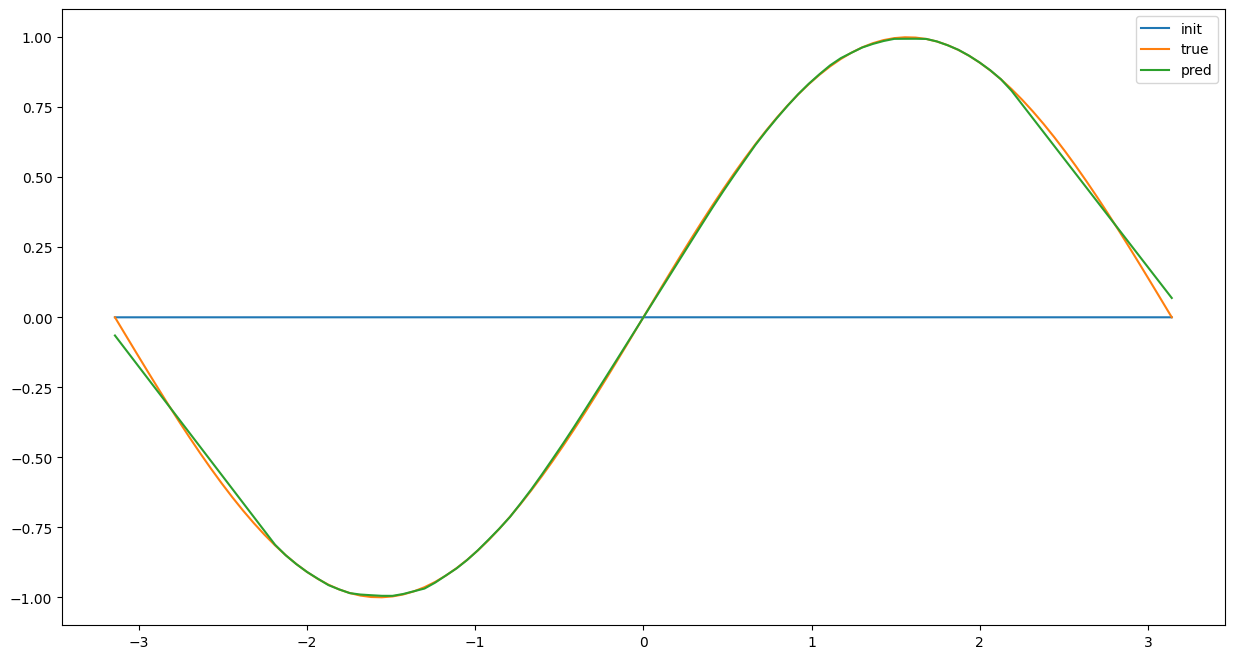

In [22]:
## L2 regularization

class Linear(Module):
    def __init__(self,input_dim,output_dim):
        super(Linear, self).__init__()
        # initilize weights
        self.W = np.random.randn(input_dim, output_dim) * 1e-2
        self.b = np.zeros((1, output_dim))
        # the linear layer's parameters should be updated
        self.with_weights = True
        
        
    def forward(self, input_array):
        res = np.zeros((input_array.shape[0], self.W.shape[1]))
        
        ## start of your code
        res = np.dot(input_array, self.W) + self.b
        ## end of your code
        
        return res

    def backward(self, input_array, output_gradient, lr = 0.05):
        res = np.zeros_like(input_array)
        ## start of your code
        lambda_reg = 0.001 # L2 regularization parameter
        # 1.Calculate the gradient of the output gradient over the input
        res = np.dot(output_gradient, self.W.T)
        # 2.Calculate the gradient of the weights, including L2 regularisation
        weight_gradient = np.dot(input_array.T, output_gradient) + 2 * lambda_reg * self.W
        # 3.Updating weights and biases
        self.W -= lr * weight_gradient
        self.b -= lr * np.sum(output_gradient, axis=0, keepdims=True)
        ## end of your code
        
        return res

layers = [
    # input layer is input data
    # L1
    Linear(1, 80),
    # L2
    ReLU(),# 
    # L3
    Linear(80, 80),
    # L4
    ReLU(),# 
    # L5
    Linear(80, 1)
]
loss = MSELoss()
model = SimpleNN(layers, loss, lr=0.05)

x = np.linspace(-np.pi, np.pi, 100).reshape(-1, 1) 
y = np.sin(x)

epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")
time0 = time.time()
while epoch < max_iteration and model.loss_value > 1e-4:
    pred_y = model(x)
    model.backward(y)
    time1 = time.time()
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}, spent time: {}'.format(epoch, max_iteration, model.loss_value, time1-time0))
    epoch += 1
plt.plot(x, pred_y, label="pred")
plt.legend()

**Your Answer:**


**Model Training and Accuracy**
 - **Training Time**: With L2 regularization, the training time may increase slightly due to the additional computation for the regularization term in the gradient update.
 - **Loss and Accuracy**: The model is likely to exhibit improved accuracy and a lower final loss compared to training without L2 regularization.

Our next task is to use this model to classfy different numbers in MNIST. First, we need to load MNIST dataset.

In [23]:
# Set device to CPU
device = "cpu"

# Define data transformation: Convert images to tensors and normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization
])

# Load MNIST dataset
path = './data/'
TRAIN_DATA = torchvision.datasets.MNIST(path, train=True, transform=transform, download=False)
VAL_DATA = torchvision.datasets.MNIST(path, train=False, transform=transform, download=False)

# Function to prepare data, sampling a specified number of samples for each digit
def prepare_data(data, num_samples):
    selected_indices = []
    label_counts = {i: 0 for i in range(10)}  # Track sample count for each digit

    # Iterate through the dataset to select the required number of samples
    for i in range(len(data)):
        _, lbl = data[i]
        if label_counts[lbl] < num_samples:
            selected_indices.append(i)
            label_counts[lbl] += 1

        # Exit the loop once all digit samples are collected
        if all(count >= num_samples for count in label_counts.values()):
            break

    # Create a subset based on the selected indices
    final_data = torch.utils.data.Subset(data, selected_indices)

    # Create DataLoader
    data_loader = torch.utils.data.DataLoader(final_data, batch_size=1, shuffle=False)
    
    return final_data, data_loader

# Set the number of samples per digit
num_samples_train = 50  # samples for each digit in training
num_samples_val = 20     # samples for each digit in validation

# Prepare training and validation data
train_data, train_data_loader = prepare_data(TRAIN_DATA, num_samples_train)
val_data, val_data_loader = prepare_data(VAL_DATA, num_samples_val)

#### Multi-class Cross-entropy Loss
The multi-class cross-entropy loss function is used to measure the difference between the predicted probability distribution of a model and the true class distribution. It can be formulated as:
$$
L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(p_{i,c})
$$

$$
p_{i,c} = \frac{e^{z_{i,c}}}{\sum_{j=1}^{C} e^{z_{i,j}}}
$$
where
\begin{align*}
L & : \text{The multi-class cross-entropy loss.} \\
N & : \text{The number of samples in the dataset.} \\
C & : \text{The number of classes.} \\
y_{i,c} & : \text{The true label for sample } i \text{ and class } c. \text{ It is } 1 \text{ if sample } i \text{ belongs to class } c, \text{ and } 0 \text{ otherwise.} \\
p_{i,c} & : \text{The predicted probability that sample } i \text{ belongs to class } c. \\
z_{i,c} & : \text{The raw score (logit)for sample} i \text{ and class } c.
\end{align*}

#### Q7 (2 points): Implement the forward propagation and backward propagation of Cross-entropy Loss.

In [24]:
class CrossEntropyLoss(Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()   
        
    def forward(self, predicted_y, y):
        N = predicted_y.shape[0]
        
        # start of your code
        # Compute probabilities using softmax
        exp_logits = np.exp(predicted_y - np.max(predicted_y, axis=1, keepdims=True))  # Scale to prevent overflow
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

        # Calculate cross-entropy loss
        loss = -np.sum(y * np.log(probabilities)) / N

        # end of your code
        return loss

    def backward(self, predicted_y, y):
        N = predicted_y.shape[0]

        # start of your code
        exp_logits = np.exp(predicted_y - np.max(predicted_y, axis=1, keepdims=True))  # Scale logits
        probabilities = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        grad = (probabilities - y) / N
        # end of your code
        return grad

In [25]:
layers = [
    # input layer is input data
    # L1
    Linear(784, 80),
    # L2
    ReLU(),  # Sigmoid(),# 
    # L3
    Linear(80, 80),
    # L4
    ReLU(),  # Sigmoid(),# 
    # L5
    Linear(80, 10)
]
loss = CrossEntropyLoss()
model = SimpleNN(layers, loss, lr=0.001)

In [26]:
epoch = 0
max_iteration = 200
while epoch < max_iteration:
    total_loss = 0
    for i, (img, lbl) in enumerate(train_data_loader):
        img = img.view(-1, 784).numpy()  # Ensure img is a numpy array
        lbl = np.eye(10)[lbl.numpy()]    # One-hot encode labels as numpy array
        pred_y = model(img)
        predicted = np.argmax(pred_y, axis=1)
        model.backward(lbl)
        total_loss += model.loss_value
    # Print loss every 5 epochs
    if epoch % 5 == 0:
        print(f'epoch {epoch}/{max_iteration}, loss: {total_loss / len(train_data_loader)}')
    epoch += 1

epoch 0/200, loss: 2.303033459123827
epoch 5/200, loss: 2.302489887336846
epoch 10/200, loss: 2.301727486490278
epoch 15/200, loss: 2.300214632471633
epoch 20/200, loss: 2.296482483025675
epoch 25/200, loss: 2.2836280409309326
epoch 30/200, loss: 2.1926419962127817
epoch 35/200, loss: 1.67766520541097
epoch 40/200, loss: 1.046663022331957
epoch 45/200, loss: 0.7489710246727675
epoch 50/200, loss: 0.614986937245102
epoch 55/200, loss: 0.5172004813330656
epoch 60/200, loss: 0.43451041702417087
epoch 65/200, loss: 0.35806433684486966
epoch 70/200, loss: 0.28929295535899235
epoch 75/200, loss: 0.2303687120333576
epoch 80/200, loss: 0.18239585537638656
epoch 85/200, loss: 0.14350982797417705
epoch 90/200, loss: 0.111923520305169
epoch 95/200, loss: 0.08783411793256882
epoch 100/200, loss: 0.06955363558780292
epoch 105/200, loss: 0.05599911213458043
epoch 110/200, loss: 0.04595476359087505
epoch 115/200, loss: 0.03840590214895573
epoch 120/200, loss: 0.032775028419991095
epoch 125/200, loss:

Now, train our model and print the results.

In [27]:
correct = 0
total = len(val_data_loader)

# Loop through the validation data loader
for img, lbl in val_data_loader:
    img = img.view(-1, 784).numpy()  # Convert img to numpy array
    lbl = np.eye(10)[lbl.numpy()]    # One-hot encode labels as numpy array
    pred_y = model(img)
    # _, predicted = torch.max(pred_y, 1)
    predicted = np.argmax(pred_y, axis=1)\
    # correct += (predicted.item() == lbl.item())
    correct += np.sum(predicted == np.argmax(lbl, axis=1))  

# Calculate accuracy
accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


Validation Accuracy: 78.50%


#### Q8 (1 points). In the training, hyperparameters like learning rate will greatly affect the performance. By adjusting the learning rate, you can observe how it influences convergence and overall accuracy. Additionally, please plot a graph to visualize the results, showing the relationship between learning rates and model performance. This will help identify the optimal learning rate for different tasks.

*Your Answer:*

Epoch 0/200, Loss: 0.006060087924612831
Epoch 5/200, Loss: 0.00607013547034647
Epoch 10/200, Loss: 0.0060698573074458905
Epoch 15/200, Loss: 0.006070133172725398
Epoch 20/200, Loss: 0.006070642346196084
Epoch 25/200, Loss: 0.0060705794407471736
Epoch 30/200, Loss: 0.0060699620938605295
Epoch 35/200, Loss: 0.006071277543346083
Epoch 40/200, Loss: 0.006068453173624058
Epoch 45/200, Loss: 0.006067805234687505
Epoch 50/200, Loss: 0.006069553601262179
Epoch 55/200, Loss: 0.0060665995854792135
Epoch 60/200, Loss: 0.006066875482891243
Epoch 65/200, Loss: 0.0060680859447267916
Epoch 70/200, Loss: 0.006067166267153115
Epoch 75/200, Loss: 0.006065915608657939
Epoch 80/200, Loss: 0.006066416573841299
Epoch 85/200, Loss: 0.006066605639040888
Epoch 90/200, Loss: 0.006065394256322192
Epoch 95/200, Loss: 0.006067366246403854
Epoch 100/200, Loss: 0.00606718138363282
Epoch 105/200, Loss: 0.00606526393424752
Epoch 110/200, Loss: 0.00606653958545777
Epoch 115/200, Loss: 0.006064531428941777
Epoch 120/200

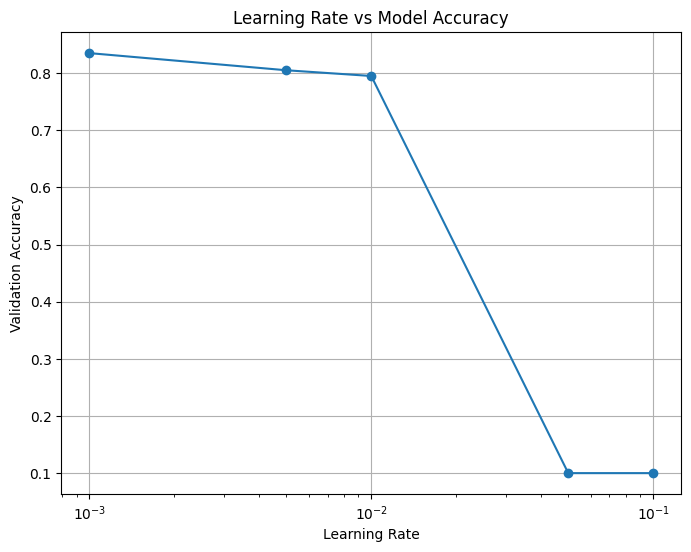

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the learning rates to test
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]

# Store results for plotting
accuracies = []

# Iterate over the learning rates
for lr in learning_rates:
    # Initialize the model with the current learning rate
    model = SimpleNN(layers, loss, lr=lr)
    
    # Training loop
    epoch = 0
    max_iteration = 200  # Number of epochs
    while epoch < max_iteration:
        total_loss = 0
        for i, (img, lbl) in enumerate(train_data_loader):
            img = img.view(-1, 784).numpy()  # Ensure img is a numpy array
            lbl = np.eye(10)[lbl.numpy()]    # One-hot encode labels as numpy array

            # Get model predictions
            pred_y = model(img)

            # Perform backward pass and update weights
            model.backward(lbl)
            total_loss += model.loss_value

        # Print loss every 5 epochs
        if epoch % 5 == 0:
            print(f"Epoch {epoch}/{max_iteration}, Loss: {total_loss / len(train_data_loader)}")
        epoch += 1

    # After training, evaluate the model on the validation set
    correct = 0
    total = len(val_data_loader)

    for img, lbl in val_data_loader:
        img = img.view(-1, 784).numpy()  # Convert img to numpy array
        lbl = np.eye(10)[lbl.numpy()]    # One-hot encode labels as numpy array

        # Get model predictions
        pred_y = model(img)

        # Get the predicted class by taking the argmax over predicted probabilities
        predicted = np.argmax(pred_y, axis=1)

        # Compare the predicted and ground truth labels
        correct += np.sum(predicted == np.argmax(lbl, axis=1))

    # Calculate accuracy
    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Learning Rate: {lr}, Validation Accuracy: {accuracy * 100:.2f}%")

# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(learning_rates, accuracies, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Learning Rate vs Model Accuracy')
plt.xscale('log')  # Use logarithmic scale for better visualization
plt.grid(True)
plt.show()


### Background for Q9 & Q10

Convolutional layers are commonly used in modern neural networks. In the following questions, you will be asked to implement a simplified 1-d convolutional neural network.

A convolution operation between a 1-d signal $s$ of length $T$ with a 1-d kernel  K of length $T'$ can be understood as sliding the kernel $K$ from left to right of signal $s$ and perform dot product at each position. 

$$s * k[\tau] = \sum_{t'=0}^{T'-1} s[\tau+t'] K[\tau]  $$

For example, let's say we have $S= [a~ b~ c~ d~ e~ f]$ and $K=[x~y~z]$, then the convolved output will be $[ax+by+cz~bx+cy+dz~cx+dy+ez~dx+ey+fz]$. 


![](./conv1d.png)
Note that such a convolution operation alters the temporal length of the input signals. Oftentimes people want the temporal lengths remain the same between the input and the output signals. Then extra padding values should be concatenated to the input signal before convolution. e.g. To make $f$ have the same temporal length as $s$, we can pad $s$ to be $s_p=[0~a~b~c~d~e~f~0]$ and conduct convolution with $K$ thereafter. 



When we have multiple   1-d signals, we can use define batch convolution using matrices.

Given signals $S\in \mathbb{R}^{B \times T}$, where $B$ is batch size and $T$ is the temporal length, together with a kernel matrix $K\in \mathbb{R}^{T'}$, where $T'$ is the temporal length of the convolution kernel, we compute the feature map $F=S*K$ as: 

$$F[i, \tau]=\sum_{t'=0}^{T'-1} S[i, \tau+t'] K[t']$$

where $i\in [0, 1, \dots, B-1]$ and $\tau\in [0, 1,\dots, T-T']$. 


 In a 1D convolutional layer, we are given (zero-padded) input signal matrix $X$ , a learnable kernel  $W$ and a learnable bias term $b$. And the layer output is $y =  X * W + b$.   *(For simplicity, we assume channel size and number of filters are both 1.)*

After the convolution operation, a scalar bias term is added to each temporal position of the output signal.

#### Q9 (0.5 point,Bonus). Derive the gradient of the 1d-convolutional layer. You should represent $\frac{\partial l}{\partial w}$, $\frac{\partial l}{\partial b}$ and $\frac{\partial l}{\partial x}$ with $\frac{\partial l}{\partial y}$, w, b, and x, where $l$ is the MSE loss without regularization, y is the output of the convolution operation without padding, w is the kernel ($K$ in the previous example), b is the bias term and x is the input to the convolutional layer. Hint: you can first calculate $\frac{\partial y_{bi}}{\partial w_{k}}$, and then apply the chain rule.

*Your Answer:*

### Convolution Operation
Let the input be $ x $, the kernel be $ w $, the bias be $ b $, and the output of the convolution operation (without padding) be $ y $. The convolution operation for a single output $ y_{bi} $ is defined as:

$$
y_{bi} = (x * w)_{bi} = \sum_{k=0}^{K-1} x_{b, i+k} \cdot w_k + b
$$

where:
- $x$ is the input signal of length $N$,
- $w$ is the kernel/filter of length $K$,
- $b$ is the bias term,
- $y$ is the output of the convolution of length $N - K + 1$.

The Mean Squared Error (MSE) loss is defined as:

$$
l = \frac{1}{2} \sum_{b=0}^{B-1} \sum_{i=0}^{N-K+1} \left( y_{bi} - y_{\text{true}, bi} \right)^2
$$

where $ B $ is the batch size, and $ N-K+1 $ is the length of the output.

---

### Gradient of the Loss with Respect to the Kernel $ w $

1. **Gradient of the loss with respect to the output $ y_{bi} $:**

$$
\frac{\partial l}{\partial y_{bi}} = y_{bi} - y_{\text{true}, bi}
$$

This is the error between the predicted output and the true output.

2. **Gradient of the output with respect to the kernel $ w_k $:**

$$
\frac{\partial y_{bi}}{\partial w_k} = x_{b, i+k}
$$

This represents how each kernel value $ w_k $ contributes to the output $ y_{bi} $.

3. **Gradient of the loss with respect to $ w_k $ using the chain rule:**

$$
\frac{\partial l}{\partial w_k} = \sum_{b=0}^{B-1} \sum_{i=0}^{N-K+1} (y_{bi} - y_{\text{true}, bi}) \cdot x_{b, i+k}
$$

---

### Gradient of the Loss with Respect to the Bias $ b $

The gradient of the loss with respect to the bias $ b $ is simpler. From the convolution operation:

$$
y_{bi} = \sum_{k=0}^{K-1} x_{b, i+k} \cdot w_k + b
$$

The gradient of the output with respect to the bias is:

$$
\frac{\partial y_{bi}}{\partial b} = 1
$$

Thus, the gradient of the loss with respect to $ b $ is:

$$
\frac{\partial l}{\partial b} = \sum_{b=0}^{B-1} \sum_{i=0}^{N-K+1} (y_{bi} - y_{\text{true}, bi})
$$

---

### Gradient of the Loss with Respect to the Input $ x $

To compute the gradient of the loss with respect to the input $ x $, we use the chain rule. For each element of $ x $, the gradient is:

$$
\frac{\partial l}{\partial x_{b, i}} = \sum_{k=0}^{K-1} \frac{\partial l}{\partial y_{b, i-k}} \cdot w_k
$$

This represents how the input $ x $ at position $ i $ contributes to the loss via the corresponding convolution operation.

---

### Summary of Gradients

- **Gradient with respect to $ w_k $:**

$$
\frac{\partial l}{\partial w_k} = \sum_{b=0}^{B-1} \sum_{i=0}^{N-K+1} (y_{bi} - y_{\text{true}, bi}) \cdot x_{b, i+k}
$$

- **Gradient with respect to $ b $:**

$$
\frac{\partial l}{\partial b} = \sum_{b=0}^{B-1} \sum_{i=0}^{N-K+1} (y_{bi} - y_{\text{true}, bi})
$$

- **Gradient with respect to $ x_{b, i} $:**

$$
\frac{\partial l}{\partial x_{b, i}} = \sum_{k=0}^{K-1} \frac{\partial l}{\partial y_{b, i-k}} \cdot w_k
$$


#### Q10 (1 points,Bonus). Implement the forward and backward propagation of a 1d convolutional layer, after which train a simple 1d convolutional network. You can use loops, although we suggest using vectorized operations. 

In [34]:
class Conv1d(Module):
    def __init__(self, kernel_size, pad_length):
        # kernel_size: the length between the middle point to the leftmost / rightmost point
        #   In other words, if you set kernel_size=a, then the kernel has 1 + 2*a parameters.
        #   For our example where the kernel is x|y|z, the kernel_size is 1.
        # pad_length: after padding, the input signal will be padded by zero on the both sides of temporal dimension, 
        #   thereby having shape B, T+2*pad_length
        #   For our example with padding, pad_length=1
        super(Conv1d, self).__init__()
        # initilize weights
        self.W = np.zeros((1, 1 + 2*kernel_size))
        self.b = np.zeros((1, 1))
        self.kernel_size = kernel_size
        self.pad_length = pad_length
        # the layer's parameters should be updated
        self.with_weights = True
        
    def forward(self, input_array):
        ## start of your code
        # Step 1: Pad the input array
        input_array_padded = np.pad(input_array, ((0, 0), (self.pad_length, self.pad_length)), mode='constant', constant_values=0)
        output_length = input_array_padded.shape[1] - self.W.shape[1] + 1  # Output length after convolution
        res = np.zeros((input_array.shape[0], output_length))

        # Apply convolution operation
        for i in range(output_length):
            res[:, i] = np.sum(input_array_padded[:, i:i + self.W.shape[1]] * self.W, axis=1) + self.b
        return res

    def backward(self, input_array, output_gradient, lr = 0.05):
        # res = np.zeros_like(input_array)
        
        ## start of your code
        # NOTE: pay attention to the padded ones when calculating gradients

        input_array_padded = np.pad(input_array, ((0, 0), (self.pad_length, self.pad_length)), mode='constant', constant_values=0)
        gradient_W = np.zeros_like(self.W)
        gradient_b = np.sum(output_gradient, axis=1, keepdims=True)  # Gradient with respect to bias

        # Compute gradient with respect to the kernel W
        for i in range(gradient_W.shape[1]):
            gradient_W += np.sum(input_array_padded[:, i:i + self.W.shape[1]] * output_gradient[:, i:i + self.W.shape[1]], axis=0)

        # Compute the gradient of the input
        gradient_input = np.zeros_like(input_array)
        for i in range(input_array.shape[1]):
            gradient_input[:, i:i + self.W.shape[1]] += np.sum(output_gradient[:, i:i + self.W.shape[1]] * self.W, axis=1)

        # Update the weights and biases using gradient descent
        self.W -= lr * gradient_W
        self.b -= lr * gradient_b

        return gradient_input
        

### Train the model
Here, we will design a simple neural network. You are free to adjust the hyperparameters.

In [35]:
layers = [
    # input layer is input data
    Conv1d(2, 3),
    ReLU(),
    Conv1d(1, 0),
    Linear(16, 64),
    ReLU(),
    Linear(64, 80),
    ReLU(),
    Linear(80, 1)
]
loss = MSELoss()
model = SimpleNN(layers, loss, lr=0.05)

In [36]:
from math import pi
x = np.random.randn(2, 16)
y = np.cos(np.random.randn(2, 1)*pi)

In [ ]:
epoch = 0
max_iteration = 20000
plt.figure(figsize=(15, 8))
pred_y = model(x)
plt.plot(x, pred_y, label="init")
plt.plot(x, y, label="true")
while epoch < max_iteration and model.loss_value > 1e-4:
    pred_y = model(x)
    model.backward(y)
    if epoch % 500 == 0:
        print(r'epoch {}/{}, loss: {}'.format(epoch, max_iteration, model.loss_value))
    epoch += 1
plt.plot(x, pred_y, label="pred")
plt.legend()